# Network analysis using the origins and divisions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import json

In [2]:
# Loading data
recensement = pd.read_excel(io="../../1832_v4.xlsx", na_values=["·","?"])
classes = pd.read_excel(io="../../histoire urbaine digitale classification metiers.xlsx", sheet_name="data",  na_values="·")
rues = pd.read_csv("../../nom_rues_et_coor.csv", sep=",")

# Adding the 'chef_vocation_categorie' column
classes = classes.rename(columns={"JOB": "chef_vocation_norm_2"})
classes = classes.rename(columns={"CLASS": "chef_vocation_categorie"})
recensement = recensement.merge(classes, on="chef_vocation_norm_2", how="outer")

# Split the values on the '/' character
split_vals = recensement['chef_vocation_categorie'].str.split('/')

# Create a new dataframe from the split values
recensement = recensement.assign(chef_vocation_categorie=split_vals).explode('chef_vocation_categorie')

# Adding coordinates
correspondances = {
    "nom_rue": [
        "ale", 
        "etraz", 
        "rue du pre", 
        "chaucrau", 
        "st laurent", 
        "st pierre", 
        "st etienne", 
        "bourg", 
        "st francois", 
        "georgette",
    ],
    "nom_rue_norm_2": [
        "rue de l'ale",
        "rue d etraz",
        "rue du pre",
        "rue de chaucrau",
        "place de st laurent",
        "rue de st pierre",
        "st etienne",
        "rue de bourg",
        "place de st froncois",
        "chemin de georgette",
    ]
}
for index, row in tqdm(recensement.iterrows(), total=len(recensement), desc="Adding coordinates"):
    nom_rue = row["nom_rue_norm_2"]
    if type(nom_rue) == float: continue # if nom_rue is NaN
    if nom_rue in correspondances["nom_rue"]:
        index = correspondances["nom_rue"].index(nom_rue)
        nom_rue = correspondances["nom_rue_norm_2"][index]
        corresponding_streets = rues.query("Nom_rue == @nom_rue")
    else:
        corresponding_streets = rues.query("Nom_rue.str.contains(@nom_rue)")
    occurences = len(corresponding_streets)
    if occurences == 1:
        recensement.at[index, "rue_x"] = corresponding_streets["X"].values[0]
        recensement.at[index, "rue_y"] = corresponding_streets["Y"].values[0]
        continue
print(f'{len(recensement.query("~rue_x.isnull()")) / len(recensement) * 100:.2f}% des personnes positionnées')

Adding coordinates: 100%|██████████| 3862/3862 [00:05<00:00, 720.92it/s]

49.30% des personnes positionnées


In [3]:
# Filter recensement by only taking the rows with a 'chef_vocation_categorie' value
recensement_filtered = recensement.query("chef_vocation_categorie.notnull()")

In [4]:
# Compute the percentage of data remaining
print(f'{len(recensement_filtered) / len(recensement):.2%} des personnes avec une profession catégorisée.')

79.52% des personnes avec une profession catégorisée.


In [5]:
# Create empty graph
G = nx.Graph()

# Add nodes for streets and job categories
streets = set(recensement['nom_rue_norm_2'].dropna())
job_categories = set(recensement['chef_vocation_categorie'].dropna())
G.add_nodes_from(streets, bipartite=0)
G.add_nodes_from(job_categories, bipartite=1)

# Iterate over each street and job category
for street in streets:
    street_data = recensement[recensement['nom_rue_norm_2'] == street]
    job_counts = street_data.groupby('chef_vocation_categorie').size()
    for job_category, count in job_counts.items():
        G.add_edge(street, job_category, weight=count)

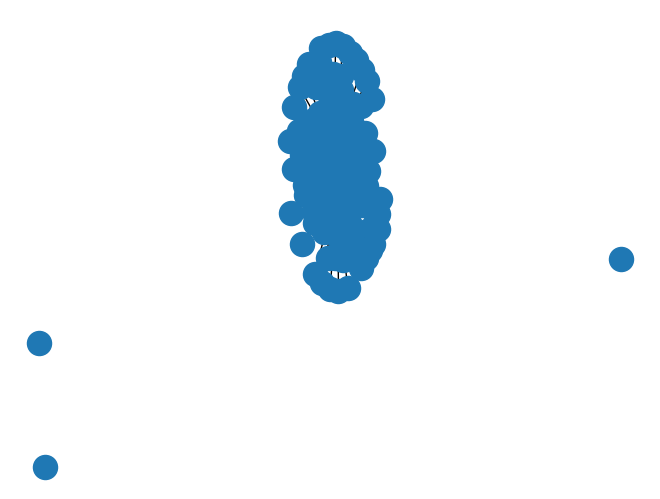

In [6]:
nx.draw(G)

In [7]:

# Get the edges of the graph with their weights
edges = G.edges(data=True)
edge_data = [(u, v, d['weight']) for u, v, d in edges]

# Create a DataFrame from the edge data
df = pd.DataFrame(edge_data, columns=['street', 'job_category', 'Weight'])

# Save the DataFrame to a CSV file
df.to_csv('bipartite_graph.csv', index=False)

In [8]:
nx.write_gexf(G, "bipartite_rue_category.gexf")

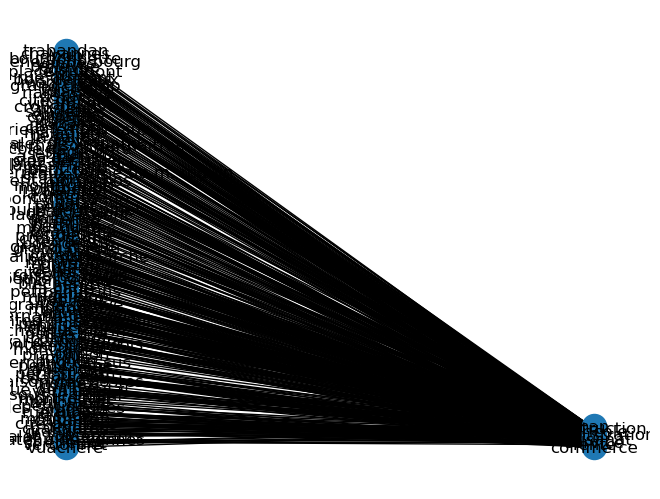

In [9]:
# Create a bipartite graph
B = nx.Graph()

# Add the streets as nodes with the 'bipartite' attribute set to 0
streets = set(recensement['nom_rue_norm_2'])
B.add_nodes_from(streets, bipartite=0)

# Add the job categories as nodes with the 'bipartite' attribute set to 1
job_categories = set(recensement['chef_vocation_categorie'])
B.add_nodes_from(job_categories, bipartite=1)

# Add the edges between the streets and job categories
edge_data = recensement.groupby(['nom_rue_norm_2', 'chef_vocation_categorie']).size().reset_index().values.tolist()
B.add_weighted_edges_from(edge_data, weight='weight')

# Get the sets of nodes in each bipartite set
streets = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
job_categories = set(B) - streets

# Define the position of each node
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(streets))
pos.update((n, (2, i)) for i, n in enumerate(job_categories))

# Draw the graph
nx.draw(B, pos=pos, with_labels=True)
plt.show()

In [10]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("./bipartite_graph.csv")

# Get unique division and job_category names
street = df["street"].unique()
job_categories = df["job_category"].unique()

# Create dictionaries to store nodes and links
nodes = []
links = []

# Iterate over divisions
for i, div in enumerate(street):
    # Add division node to nodes dictionary
    nodes.append({"Id": str(i), "label": str(div), "type": "street", "size": int(df[df["street"] == div]["Weight"].sum())})
    
    # Iterate over job categories and add corresponding links
    for j, cat in enumerate(job_categories):
        weight = int(df[(df["street"] == div) & (df["job_category"] == cat)]["Weight"].sum())
        if weight > 0:
            links.append({"Source": str(i), "Target": str(cat), "Weight": weight})
            
# Iterate over job categories
for i, cat in enumerate(job_categories):
    # Add job category node to nodes dictionary
    nodes.append({"Id": str(cat), "label": str(cat), "type": "job_category", "size": int(df[df["job_category"] == cat]["Weight"].sum())})
    
# Create JSON dictionary
json_dict = {"nodes": nodes, "links": links}

# Write JSON dictionary to file
with open("./bipartite_street_type_metiers.json", "w") as f:
    json.dump(json_dict, f, indent=4)